In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import healpy as hp
import numba
from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from scipy.special import spherical_jn, jv
from scipy import integrate

In [5]:
import camb
from camb import model, initialpower


In [6]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);
results = camb.get_results(pars)

In [7]:
cmb = results.get_cmb_power_spectra(pars,lmax=10, raw_cl=True)

In [8]:
results.get_cmb_power_spectra?

In [9]:
cmb = results.get_cmb_power_spectra(pars,lmax=10, raw_cl=True)
cmb['lensed_scalar'][:4,0]

array([0.00000000e+00, 0.00000000e+00, 1.36919629e-10, 6.48510678e-11])

In [10]:
bkd = camb.get_background(pars)

In [33]:
ks = np.logspace(-4,1)
eta = np.linspace(1, 400, 300)

In [86]:
zev = results.get_redshift_evolution(ks, z)

In [87]:
zev.shape

(2, 300, 24)

In [54]:
%timeit spherical_jn(2,range(100))

21.2 µs ± 841 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [56]:
bkd.conformal_time(1100)

277.74200313652966

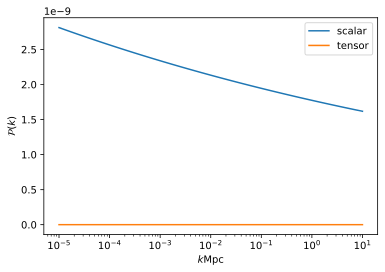

In [41]:
k=10**np.linspace(-5, 1, 50)
pars.InitPower.set_params(ns=0.96, r=0.) #this functions imposes inflation consistency relation by default
scalar_pk= pars.scalar_power(k)
tensor_pk= pars.tensor_power(k)
plt.semilogx(k,scalar_pk);
plt.semilogx(k,tensor_pk);
plt.xlabel(r'$k \rm{Mpc}$')
plt.ylabel(r'${\cal P}(k)$')
plt.legend(['scalar', 'tensor']);

In [12]:
z = np.linspace(0,8,300)
ks = [0.02,0.1,1]
ev = results.get_redshift_evolution(ks, z, ['growth','T_source'])


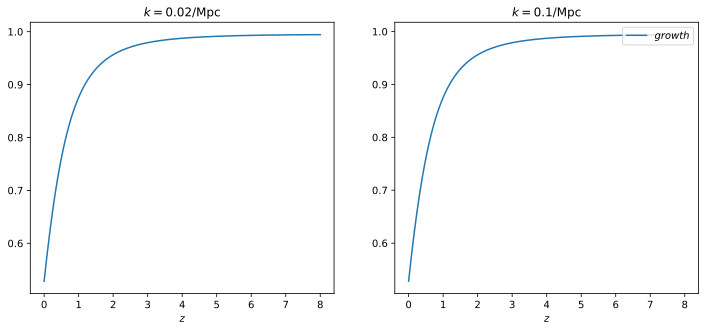

In [13]:
_, axs= plt.subplots(1,2, figsize=(12,5))
for i, ax in enumerate(axs):
    ax.plot(z,ev[i,:, 0])
#     ax.loglog(z,ev[i,:, 1])
    ax.set_title(r'$k= %s/\rm{Mpc}$'%ks[i])
    ax.set_xlabel('$z$');
plt.legend([r'$growth$',r'$\Delta_\gamma$'], loc = 'upper right');

In [20]:
from scipy.interpolate import UnivariateSpline

In [21]:
growth_eta = UnivariateSpline(bkd.conformal_time(z[::-1]),ev[i,:, 0][::-1], ext=3)

In [15]:
UnivariateSpline?

Object `UnivariateSpline` not found.


In [43]:
class pSZ():
    def __init__(self):
        self.pars = camb.CAMBparams()
        #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
        self.pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
        self.pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        self.pars.set_for_lmax(2500, lens_potential_accuracy=0);
        results = camb.get_results(self.pars)
        self.bkd = camb.get_background(self.pars)
        self.eta_star = bkd.conformal_time(1089)

        cmb = results.get_cmb_power_spectra(pars,lmax=10, raw_cl=True)
        self.cltt = np.copy(cmb['lensed_scalar'][:,0])
        
        z = np.linspace(0,8,300)
        ev = results.get_redshift_evolution(1e-2, z, ['growth'])

        self.growth_eta = UnivariateSpline(bkd.conformal_time(z[::-1]), ev[:, 0][::-1], ext=3)
        self.der_growtg_eta = self.growth_eta.derivative()
    
    def integrand_ISW(self, etap, eta, k, ell=2):
        return spherical_jn(ell, k*(eta-etap)) * self.der_growtg_eta(etap)

    def SW(self, eta, k, ell=2):
        return spherical_jn(ell, k*(eta-self.eta_star))/3.
    
    def Delta(self, k, r, ell=2):
        eta = self.bkd.tau0 - r
        return SW(eta, k, ell=ell) + integrate.quad(self.integrand_ISW, self.eta_star, eta, args=(eta, k, ell), epsabs=0, epsrel=1e-2)[0]

    def f_ell(self, ell):
        return np.math.factorial(ell+2)/(np.math.factorial(ell-2))
    
    def h_ell(self, k, z, ell=2):
        r = self.bkd.comoving_radial_distance(z)
        x = k*(self.bkd.tau0-self.bkd.conformal_time(z))
        f_ell = np.sqrt(np.math.factorial(ell+2)/(6*np.math.factorial(ell-2))) * spherical_jn(ell, x) / (30*x**2)
        return f_ell * self.Delta(k, r, ell=ell)
    
    def integrand_xi(self, k, r, rp, ell=2):
        fact = 81/100 * np.pi * self.f_ell(ell) 
        xr  = spherical_jn(ell, k*r)/(k*r)**2
        xrp = spherical_jn(ell, k*rp)/(k*rp)**2
        return fact * xr * xrp * self.Delta(k, r, ell=2) * self.Delta(k, rp, ell=2) * self.pars.scalar_power(k)/ k
    
    def integrand_zeta(self, k, r, ell=2):
        fact = -27/25 * np.pi * self.f_ell(ell)**0.5
        xr  = spherical_jn(ell, k*r)/(k*r)**2
        return fact * xr  * self.Delta(k, r, ell=2) * self.Delta(k, 0, ell) * self.pars.scalar_power(k)/ k
    
    def xi(self, z, zp, ell=2, kmin=1e-5, kmax=1e-1, epsabs=0., epsrel=1e-2, limit=50):
        return integrate.quad(theory.integrand_xi, kmin, kmax, args=(self.bkd.comoving_radial_distance(z),self.bkd.comoving_radial_distance(z))  ,epsabs=epsabs, epsrel=epsrel, limit=limit)[0] 
    
    def zeta(self, z, ell=2, kmin=1e-5, kmax=1e-1, epsabs=0., epsrel=1e-2, limit=50):
        return integrate.quad(theory.integrand_zeta, kmin, kmax, args=(self.bkd.comoving_radial_distance(z),ell), epsabs=epsabs, epsrel=epsrel, limit=limit)[0] 
    
    def R(self, z, ell=2, kmin=1e-5, kmax=1e-1, epsabs=0., epsrel=1e-2, limit=50):
        xi_ = self.xi(z, z, ell=ell, kmin=kmin, kmax=kmax, epsabs=epsabs, epsrel=epsrel, limit=limit)[0]
        zeta_ = self.zeta(z, ell=ell, kmin=kmin, kmax=kmax, epsabs=epsabs, epsrel=epsrel, limit=limit)[0]
        return np.abs(zeta_)/np.sqrt(xi_*self.cltt[ell])

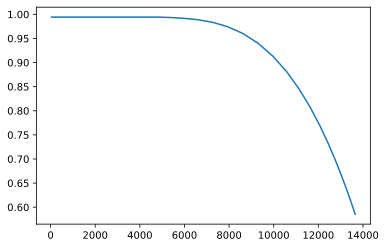

In [187]:
plt.plot(bkd.conformal_time(np.logspace(-1,4)[::-1]), growth_eta(bkd.conformal_time(np.logspace(-1,4)[::-1])))

In [30]:
eta_star = bkd.conformal_time(1100)

In [31]:
eta_star

277.74200313652966

In [22]:
der_growtg_eta = growth_eta.derivative()

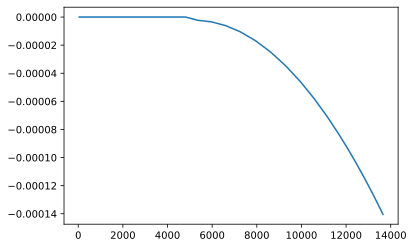

In [23]:
plt.plot(bkd.conformal_time(np.logspace(-1,4)[::-1]), der_growtg_eta(bkd.conformal_time(np.logspace(-1,4)[::-1])))

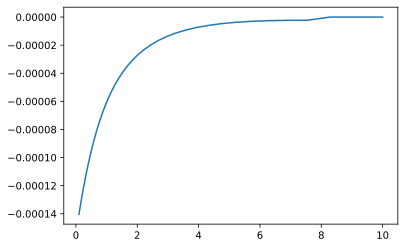

In [24]:
plt.plot(np.logspace(-1,1)[::-1], der_growtg_eta(bkd.conformal_time(np.logspace(-1,1)[::-1])))

In [25]:
def integrand_ISW(etap, eta, k, ell=2):
    return spherical_jn(ell, k*(eta-etap)) * der_growtg_eta(etap)

def SW(eta, k, ell=2):
    return spherical_jn(ell, k*(eta-eta_star))/3.
    

In [26]:
eta_arr = np.linspace(0,bkd.tau0,500)

[[<matplotlib.lines.Line2D at 0x11a859978>],

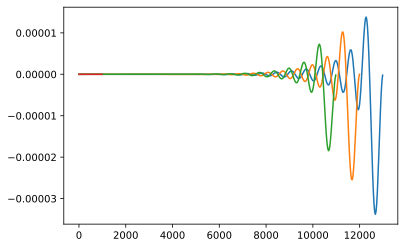

In [27]:
[plt.plot(eta_arr, integrand_ISW(eta_arr, eta_, 0.01)) for eta_ in [13000,12000,11000,1000]]

[[<matplotlib.lines.Line2D at 0x11fa5c198>],

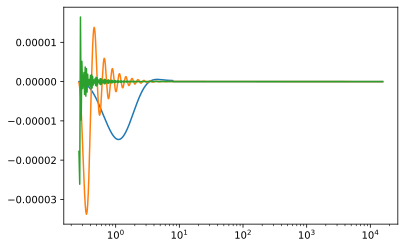

In [28]:
[plt.semilogx(bkd.redshift_at_conformal_time(eta_arr), integrand_ISW(eta_arr, 13000, k_)) for k_ in [1e-3,1e-2,1e-1]]

[[<matplotlib.lines.Line2D at 0x11fde2470>],

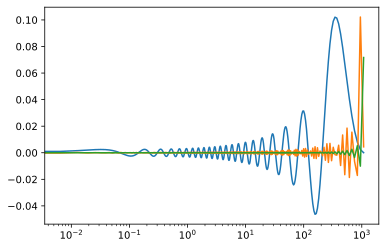

In [32]:
[plt.semilogx(bkd.redshift_at_conformal_time(eta_arr), SW(eta_arr,k_)) for k_ in [1e-2,1e-1,1]]

In [257]:
%timeit integrate.quad(integrand_ISW, eta_star, bkd.conformal_time(1), args=(bkd.conformal_time(1), 0.01, 2))

13.3 ms ± 591 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
def Delta(k, r, ell=2):
    eta = bkd.tau0 - r
#     return integrate.quad(integrand_ISW, eta_star, eta, args=(eta, k, ell))
    return SW(eta, k, ell=ell)# + integrate.quad(integrand_ISW, eta_star, eta, args=(eta, k, ell))[0]

def h_ell(k, z, ell=2):
    r = bkd.comoving_radial_distance(z)
    x = k*(bkd.tau0-bkd.conformal_time(z))
#     print(r, bkd.tau0-r, x)
    f_ell = np.sqrt(np.math.factorial(ell+2)/(6*np.math.factorial(ell-2))) * spherical_jn(ell, x) / (30*x**2)
#     print(f_ell)
    return f_ell * Delta(k, r, ell=ell)

In [34]:
Delta(0.001, 0)

-0.024179189339983077

In [35]:
bkd.conformal_time?

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


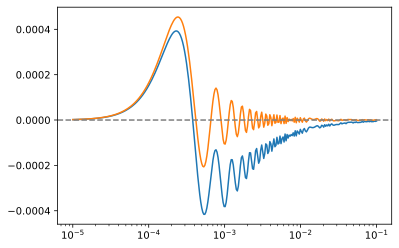

In [341]:
k_arr = np.logspace(-5,-1,300)
plt.semilogx(k_arr, [theory.h_ell(_k_, 1e-4, ell=2) for _k_ in k_arr])
plt.semilogx(k_arr, [h_ell(_k_, 1e-4, ell=2) for _k_ in k_arr])
# plt.semilogx(k_arr, [h_ell(_k_, 0.5 , ell=2) for _k_ in k_arr])
# plt.semilogx(k_arr, [h_ell(_k_, 1   , ell=2) for _k_ in k_arr])
plt.axhline(ls='--', c='grey')
# plt.xlabel(r'$$')

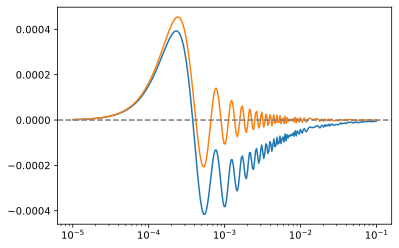

In [45]:
k_arr = np.logspace(-5,-1,300)
plt.semilogx(k_arr, [theory.h_ell(_k_, 1e-4, ell=2) for _k_ in k_arr])
plt.semilogx(k_arr, [h_ell(_k_, 1e-4, ell=2) for _k_ in k_arr])
# plt.semilogx(k_arr, [h_ell(_k_, 0.5 , ell=2) for _k_ in k_arr])
# plt.semilogx(k_arr, [h_ell(_k_, 1   , ell=2) for _k_ in k_arr])
plt.axhline(ls='--', c='grey')
# plt.xlabel(r'$$')

In [44]:
theory = pSZ()

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


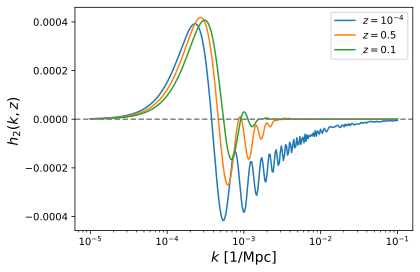

In [337]:
k_arr = np.logspace(-5,-1,300)
plt.semilogx(k_arr, [theory.h_ell(_k_, 1e-4, ell=2) for _k_ in k_arr], label=r'$z=10^{-4}$')
plt.semilogx(k_arr, [theory.h_ell(_k_, 0.5 , ell=2) for _k_ in k_arr], label=r'$z=0.5$')
plt.semilogx(k_arr, [theory.h_ell(_k_, 1   , ell=2) for _k_ in k_arr], label=r'$z=1$')
plt.axhline(ls='--', c='grey')
plt.xlabel(r'$k$ [1/Mpc]', size=14)
plt.ylabel(r'$h_2(k,z)$ ', size=14)
plt.legend()
plt.tight_layout()

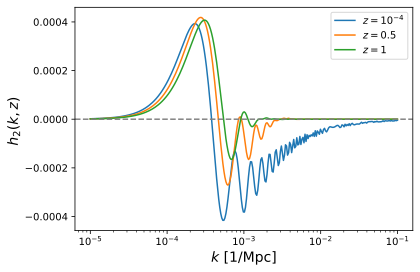

In [46]:
k_arr = np.logspace(-5,-1,300)
plt.semilogx(k_arr, [theory.h_ell(_k_, 1e-4, ell=2) for _k_ in k_arr], label=r'$z=10^{-4}$')
plt.semilogx(k_arr, [theory.h_ell(_k_, 0.5 , ell=2) for _k_ in k_arr], label=r'$z=0.5$')
plt.semilogx(k_arr, [theory.h_ell(_k_, 1   , ell=2) for _k_ in k_arr], label=r'$z=1$')
plt.axhline(ls='--', c='grey')
plt.xlabel(r'$k$ [1/Mpc]', size=14)
plt.ylabel(r'$h_2(k,z)$ ', size=14)
plt.legend()
plt.tight_layout()

In [48]:
theory.h_ell(1e-3, 1e-4, ell=2)

-0.0003840506016943549

In [59]:
theory.SW(theory.bkd.tau0 - 1e4, 1e-2, ell=2)

-0.0036103029550681384

4084.279013178204

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


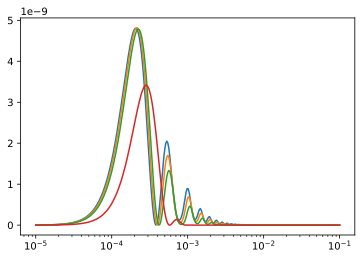

In [357]:
plt.semilogx(k_arr, [theory.integrand_xi(_k_, 100, 100, ell=2) for _k_ in k_arr], )
plt.semilogx(k_arr, [theory.integrand_xi(_k_, 500, 500, ell=2) for _k_ in k_arr], )
plt.semilogx(k_arr, [theory.integrand_xi(_k_, 1000, 1000, ell=2) for _k_ in k_arr], )
plt.semilogx(k_arr, [theory.integrand_xi(_k_, 4000, 4000, ell=2) for _k_ in k_arr], )

In [404]:
%timeit integrate.simps([theory.integrand_xi(_k_, 100, 100, ell=2) for _k_ in k_arr], k_arr)

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


5.85 s ± 328 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [601]:
int_xi_pnt = [theory.integrand_xi(_k_, bkd.comoving_radial_distance(1.78), bkd.comoving_radial_distance(1.78), ell=2) for _k_ in k_arr]

In [633]:
int_zeta_pnt = [theory.integrand_zeta(_k_, bkd.comoving_radial_distance(0.05), ell=2) for _k_ in k_arr]

In [635]:
int_xi = UnivariateSpline(k_arr, int_xi_pnt, k=5, s=0)
int_zeta = UnivariateSpline(k_arr, int_zeta_pnt, k=5, s=0)

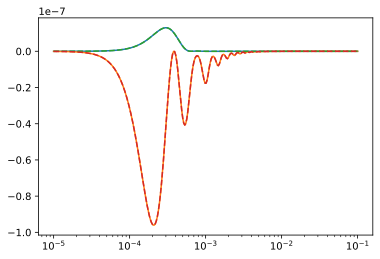

In [636]:
ks = np.logspace(-5,1e-1,1000)
plt.semilogx(k_arr, int_xi_pnt)
plt.semilogx(k_arr, int_zeta_pnt)
# plt.semilogx(k_arr, int_xi_pnt2,':')
plt.semilogx(k_arr, int_xi(k_arr),'--')
plt.semilogx(k_arr, int_zeta(k_arr),'--')

In [637]:
int_xi.integral(1e-5,1e-1); int_zeta.integral(1e-5,1e-1)

-3.440005586559323e-11

In [405]:
%timeit integrate.quad(theory.integrand_xi, 1e-5, 1e-2, args=(100,100), epsabs=0, epsrel=1e-2)

3.77 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [457]:
zs = np.linspace(0.1,2)

In [60]:
zs2 = np.linspace(0.05,2,15)

In [61]:
zs2

array([0.05      , 0.18928571, 0.32857143, 0.46785714, 0.60714286,
       0.74642857, 0.88571429, 1.025     , 1.16428571, 1.30357143,
       1.44285714, 1.58214286, 1.72142857, 1.86071429, 2.        ])

In [667]:
xi_2 = [integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_),bkd.comoving_radial_distance(_z_))  ,epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]
xi_3 = [integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_),bkd.comoving_radial_distance(_z_),3),epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]
xi_4 = [integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_),bkd.comoving_radial_distance(_z_),4),epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]
xi_5 = [integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_),bkd.comoving_radial_distance(_z_),5),epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


In [638]:
print(integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(1.78),bkd.comoving_radial_distance(1.78)), epsabs=0, epsrel=1e-3))
print(integrate.quad(theory.integrand_zeta, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(0.25)), epsabs=0, epsrel=1e-3))




(3.5620557011481172e-12, 3.581594155842923e-17)
(-2.8203129651410164e-11, 2.3103465680221428e-14)


In [62]:
zeta_2 = [integrate.quad(theory.integrand_zeta, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_)),   epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]
zeta_3 = [integrate.quad(theory.integrand_zeta, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_),3), epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]
zeta_4 = [integrate.quad(theory.integrand_zeta, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_),4), epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]
zeta_5 = [integrate.quad(theory.integrand_zeta, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(_z_),5), epsabs=0, epsrel=1e-2, limit=50) for _z_ in zs2]

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


In [669]:
xi_2 = np.asarray(xi_2)
xi_3 = np.asarray(xi_3)
xi_4 = np.asarray(xi_4)
xi_5 = np.asarray(xi_5)


In [63]:
zeta_2 = np.asarray(zeta_2)
zeta_3 = np.asarray(zeta_3)
zeta_4 = np.asarray(zeta_4)
zeta_5 = np.asarray(zeta_5)

In [64]:
zeta_2

array([[-3.44044317e-11,  2.19892280e-13],
       [-3.00312169e-11,  2.67689027e-13],
       [-2.60226217e-11,  8.32477593e-14],
       [-2.27061626e-11,  2.06548629e-14],
       [-2.00106552e-11,  6.72499939e-14],
       [-1.78040606e-11,  1.08017812e-13],
       [-1.59671311e-11,  2.91414264e-14],
       [-1.44087456e-11,  3.51769897e-14],
       [-1.30642748e-11,  1.83171912e-14],
       [-1.18885226e-11,  1.89077614e-14],
       [-1.08506464e-11,  1.55567131e-14],
       [-9.92926193e-12,  1.37289504e-14],
       [-9.10785436e-12,  1.10368113e-14],
       [-8.37560751e-12,  9.58629533e-15],
       [-7.72318721e-12,  9.19021781e-15]])

Text(0, 0.5, '$\\xi_{\\ell}(z,z^{\\prime})$ [$\\mu$K$^2$]')

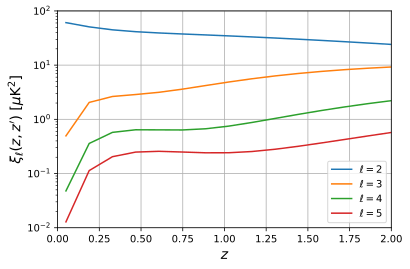

In [673]:
plt.semilogy(zs2, xi_2[:,0]*(2.725e6)**2, label=r'$\ell=2$')
plt.semilogy(zs2, xi_3[:,0]*(2.725e6)**2, label=r'$\ell=3$')
plt.semilogy(zs2, xi_4[:,0]*(2.725e6)**2, label=r'$\ell=4$')
plt.semilogy(zs2, xi_5[:,0]*(2.725e6)**2, label=r'$\ell=5$')
plt.ylim(1e-2,1e2)
plt.xlim(0,2)
plt.legend(loc='best')
plt.grid()
plt.xlabel(r'$z$', size=14)
plt.ylabel(r'$\xi_{\ell}(z,z^{\prime})$ [$\mu$K$^2$]', size=14)

In [538]:
cmb['lensed_scalar'][3,0]

1.2385641606822973e-10

Text(0, 0.5, '$|R_{\\ell}(z)|$')

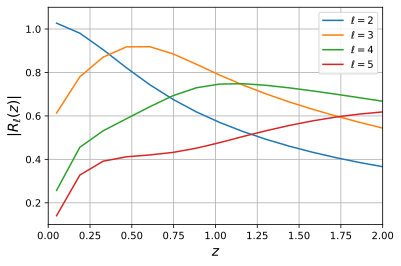

In [674]:
plt.plot(zs2, np.abs(zeta_2[:,0])/np.sqrt(xi_2[:,0]*cmb['lensed_scalar'][2,0]), label=r'$\ell=2$')
plt.plot(zs2, np.abs(zeta_3[:,0])/np.sqrt(xi_3[:,0]*cmb['lensed_scalar'][3,0]), label=r'$\ell=3$')
plt.plot(zs2, np.abs(zeta_4[:,0])/np.sqrt(xi_4[:,0]*cmb['lensed_scalar'][4,0]), label=r'$\ell=4$')
plt.plot(zs2, np.abs(zeta_5[:,0])/np.sqrt(xi_5[:,0]*cmb['lensed_scalar'][5,0]), label=r'$\ell=5$')
plt.xlim(0,2)
plt.ylim(0.1,1.1)
plt.legend(loc='best')
plt.grid()
plt.xlabel(r'$z$', size=14)
plt.ylabel(r'$|R_{\ell}(z)|$', size=14)

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


(0.0001, 100.0)

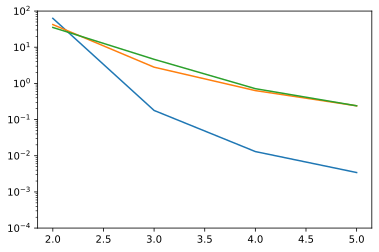

In [676]:
ells = [2,3,4,5]
plt.semilogy(ells, [integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(0.025),bkd.comoving_radial_distance(0.025), ell), epsabs=0, epsrel=1e-3, limit=100)[0]*(2.725e6)**2 for ell in ells])
plt.semilogy(ells, [integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(0.425),bkd.comoving_radial_distance(0.425), ell), epsabs=0, epsrel=1e-3, limit=100)[0]*(2.725e6)**2 for ell in ells])
plt.semilogy(ells, [integrate.quad(theory.integrand_xi, 1e-5, 1e-1, args=(bkd.comoving_radial_distance(0.975),bkd.comoving_radial_distance(0.975), ell), epsabs=0, epsrel=1e-3, limit=100)[0]*(2.725e6)**2 for ell in ells])
plt.ylim(1e-4,1e2)


In [680]:
theory.R(0.025)

1.029897098573648

In [681]:
smica = hp.read_map('data/smica_nside512.fits')

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


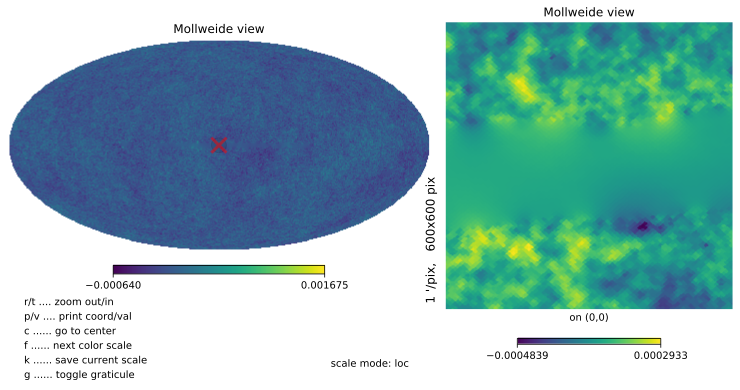

In [683]:
hp.mollzoom(smica)

In [689]:
np.sqrt(theory.cltt[2])*(1e6)

11.701266120467267

In [690]:
alms_smica = hp.map2alm(smica)

In [697]:
lmax_smica = hp.Alm.getlmax(alms_smica.size)

In [704]:
hp.Alm.getidx(lmax_smica, 2, 1)

1537

In [705]:
alms_smica[hp.Alm.getidx(lmax_smica, 2, 1)]

(-2.6997730990280867e-06+9.1367209103969e-06j)

In [735]:
lmax = 10
ells = np.arange(2,lmax+1)
zeta_ell_z0p2 = np.asarray([theory.zeta(0.2, ell) for ell in ells])

In [737]:
zeta_ell_z0p2/theory.cltt[2:lmax+1]

array([-0.21691696, -0.05237067, -0.01731883, -0.00887393, -0.00552391,
       -0.00377663, -0.00274601, -0.00208834, -0.00163978])

In [739]:
plm = np.zeros(lmax_smica+1)
plm[2:lmax+1] = zeta_ell_z0p2/theory.cltt[2:lmax+1]

In [748]:
plm

array([ 0.        ,  0.        , -0.21691696, ...,  0.        ,
        0.        ,  0.        ])

In [749]:
I_z0p5, Q_z0p5, U_z0p5 = hp.alm2map([np.zeros_like(alms_smica),hp.almxfl(alms_smica,plm),np.zeros_like(alms_smica)], 512)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


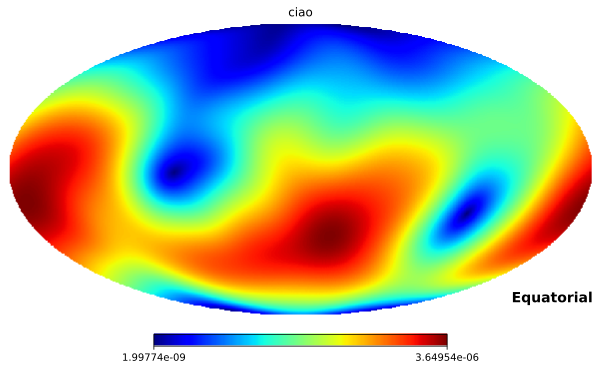

In [757]:
hp.mollview(np.sqrt(Q_z0p5**2+U_z0p5**2), cmap='jet', coord=['G','C'], title='ciao')

In [1069]:
def PlotRemoteQuadrupole(z, lmax=5, nside=512, cmap='jet', coord=['G','C'], plot=False, return_QU=False):
    ells = np.arange(2,lmax+1)
    zeta_tmp = np.asarray([theory.zeta(z, ell) for ell in ells])
    plm_tmp = np.zeros(lmax_smica+1)
    plm_tmp[2:lmax+1] = zeta_tmp/theory.cltt[2:lmax+1]
    I_tmp, Q_tmp, U_tmp = hp.alm2map([np.zeros_like(alms_smica),hp.almxfl(alms_smica,plm_tmp),np.zeros_like(alms_smica)], nside)
    if plot: hp.mollview(np.sqrt(Q_tmp**2+U_tmp**2), cmap=cmap, coord=coord, title='z = %f'%z )
    if return_QU:
        return np.sqrt(Q_tmp**2+U_tmp**2), Q_tmp, U_tmp
    else:
        return np.sqrt(Q_tmp**2+U_tmp**2)

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:55: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


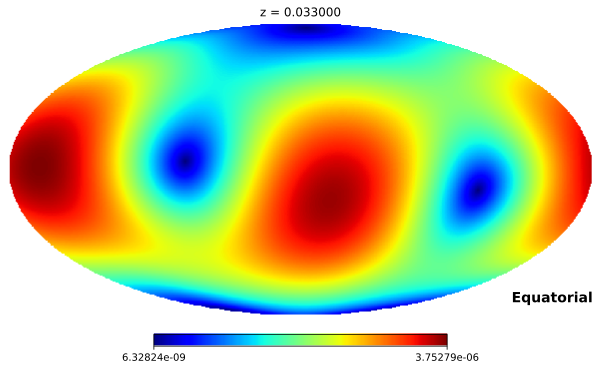

In [759]:
PlotRemoteQuadrupole(0.033)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


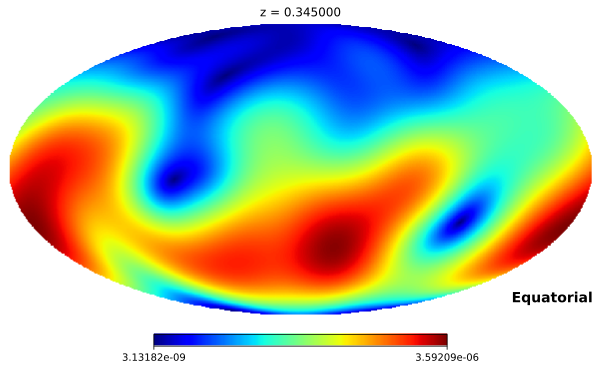

In [760]:
PlotRemoteQuadrupole(0.345)

In [844]:
mask_3g_original = hp.read_map('/Users/fbianchini/Downloads/3g_mask.fits')

/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [845]:
mask_3g_original = hp.ud_grade(mask_3g_original, nside_out=512)

In [800]:
mask_3g[mask_3g>0] = 1

In [801]:
mask_3g[mask_3g==0] = 0.8

In [802]:
r = hp.Rotator(coord=['C','G']) 
mask_3g_gal = r.rotate_map_alms(mask_3g)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [846]:
mask_3g_gal_binary = mask_3g_original.copy()
mask_3g_gal_binary = r.rotate_map_alms(mask_3g_gal_binary)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:55: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


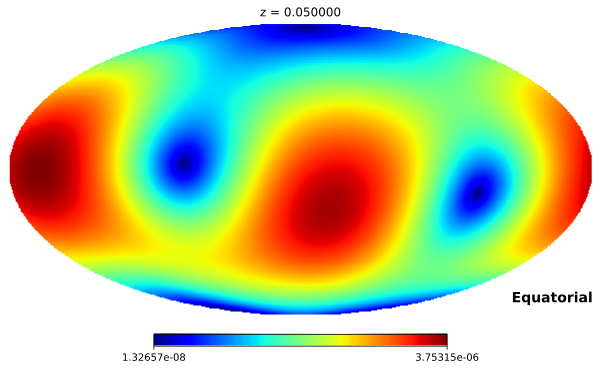

In [766]:
Pc_z0p05 = PlotRemoteQuadrupole(0.05)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


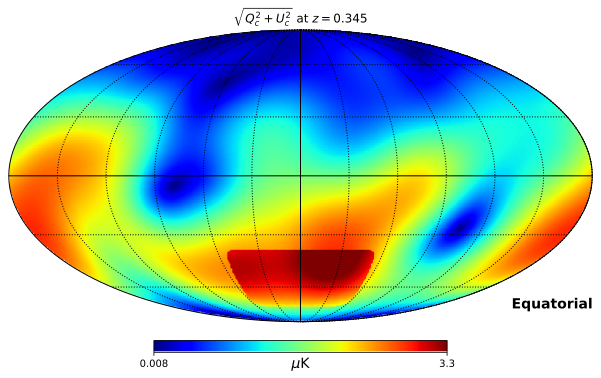

In [894]:
hp.mollview(Pc_z0p345*1e6*mask_3g_gal, cmap='jet',coord=['G','C'], min=0.008, max=3.3, title=r'$\sqrt{Q_c^2+U_c^2}$ at $z=0.345$', unit=r'$\mu$K')
hp.graticule()
plt.savefig('plots/pc_z0p345.pdf')

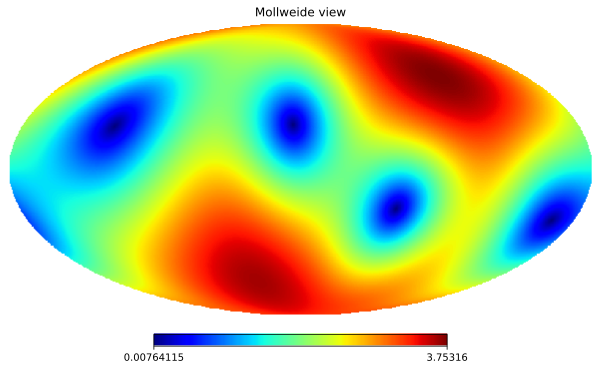

In [808]:
hp.mollview(Pc_z0p05*1e6, cmap='jet')

In [811]:
Pc_z0p05.mean()*1e6

2.167537220519313

In [888]:
Pc_mean_full = np.zeros_like(zs2)
Pc_mean_3g   = np.zeros_like(zs2)
for iz, _z_ in enumerate(zs2):
    print(iz,_z_)
    Pc_tmp = PlotRemoteQuadrupole(_z_, lmax=5, nside=512, plot=False)
    Pc_mean_full[iz] = Pc_tmp.mean()*1e6
    Pc_mean_3g[iz]   = (Pc_tmp[np.where(mask_3g_gal_binary==1)]).mean()*1e6
    

0 0.05


/Users/fbianchini/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:55: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
1 0.18928571428571428
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
2 0.32857142857142857
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
3 0.46785714285714286
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
4 0.6071428571428572
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
5 0.7464285714285714
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
6 0.8857142857142858
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
7 1.0250000000000001
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
8 1.1642857142857144
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
9 1.3035714285714286
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
10 1.4428571428571428
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
11 1.5821428571428573
Sigma is 0.00000

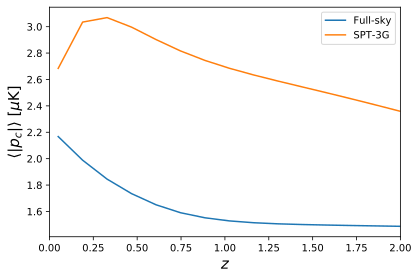

In [892]:
plt.plot(zs2, Pc_mean_full, label='Full-sky')
plt.plot(zs2, Pc_mean_3g, label='SPT-3G')
plt.xlabel(r'$z$', size=15)
plt.ylabel(r'$\langle|p_c|\rangle$ [$\mu$K]', size=15)
plt.legend(loc='best')
plt.xlim(0,2)
plt.tight_layout()
plt.savefig('plots/mean_pc_z.pdf')

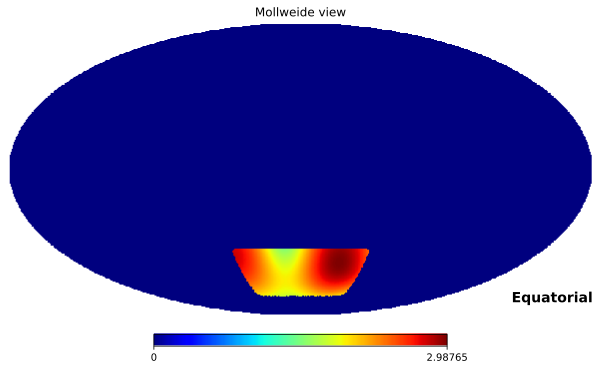

In [891]:
hp.mollview(Pc_tmp*mask_3g_gal_binary*1e6, coord=['G','C'], cmap='jet')

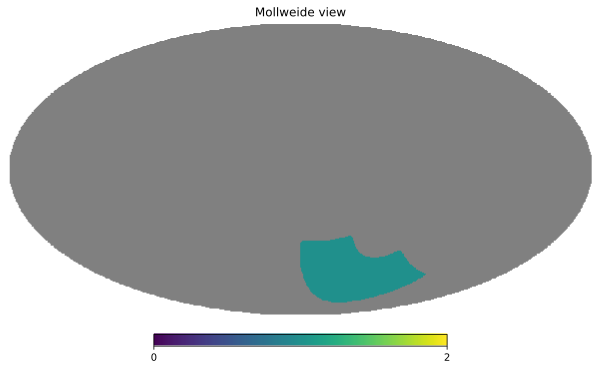

In [873]:
hp.mollview(mask_3g_gal_binary)

In [870]:
mask_3g_gal_binary[mask_3g_gal_binary<0.2] = hp.UNSEEN

In [885]:
mask_3g_gal_binary[mask_3g_gal_binary==hp.UNSEEN] = 0

In [883]:
Pc_tmp[np.where(mask_3g_gal_binary==1)[0]].mean()*1e6

2.3587521692259794

## Profiles

In [1001]:
km2Mpc  = (u.km).to(u.Mpc)
Msun2kg = (u.Msun).to(u.kg)
m2Mpc   = (u.m).to(u.Mpc)
Mpc2m   = (u.Mpc).to(u.m)
G       = c.G.value
sigma_T = c.sigma_T.value
mp      = c.m_p.to('kg').value

In [1058]:
def GammaTau(x, c500=1.156):
    """
    Electron density cNFW profile
    Eq. 11 from Louis+17
    ! x = r/R500
    """
    x0 = 0.02 * 0.5 # R200/R500 ~ 1/2
    return ( (x+x0)*c500*(1+x*c500)**2)**(-1)

def gTau(x, c500=1.156, theta500=1):
    int_num = lambda xz: GammaTau(np.sqrt(xz**2+x**2), c500=c500)  
    num = 2 * integrate.quad(int_num, 0, np.inf, epsabs=0, epsrel=1e-3)[0]
    int_den = lambda xr: GammaTau(xr, c500=c500)  
    den = 4 * np.pi * theta500**2 * integrate.quad(int_den, 0, 1, epsabs=0, epsrel=1e-3)[0]
    return num/den

def cNFW(theta, z, M=1e14, c500=1.177, fb=0.16, fH=0.76, mass_def=500):
    d_A     = bkd.angular_diameter_distance(z) # [Mpc]
    rho_c_z = 3.*(bkd.hubble_parameter(z)*km2Mpc)**2/(8.*np.pi*G)# [kg/m^3]
    r500 = (((M*Msun2kg/(500*4.*np.pi/3.))/rho_c_z)**(1./3.))*m2Mpc # [Mpc]
    rs = r500/c500
    r0 = 0.01 * r500 
    R = np.radians(theta/60.) * d_A # [Mpc]
    print(rho_c_z, r500, d_A, np.rad2deg(rs/d_A)*60)
    delta_c = (500/3.)*(c500**3.)/(np.log(1.+c500)-c500/(1.+c500))

    Lmax = np.inf#1000*r500
    
    norm_for_int = 2. * rho_c_z * rs**3. * sigma_T * delta_c * fb * (1+fH) / (2*mp) * Mpc2m#[kg/m^3 Mpc^3 m^2 kg^-1]
    tau = np.zeros_like(R)
    
    for ii in range(len(R)):
#         print(R[ii])
        def integrand(r):
            return  1 / ( (r0 + r) * (rs + r)**2. ) * ( r / np.sqrt(r**2. - R[ii]**2.))
        tau[ii] = integrate.quad(integrand, R[ii], Lmax, epsabs=0, epsrel=1e-4)[0]

    return norm_for_int*tau

def cNFW_grid(z, M=1e14, c500=1.177, reso=0.2, theta_max=10,fb=0.16, fH=0.76, mass_def=500):
    theta_x,theta_y = np.meshgrid(np.arange(-theta_max,theta_max+reso,reso), np.arange(-theta_max,theta_max+reso,reso))
    theta   = np.sqrt(theta_x**2+theta_y**2) # arcmin
    d_A     = bkd.angular_diameter_distance(z) # [Mpc]
    rho_c_z = 3.*(bkd.hubble_parameter(z)*km2Mpc)**2/(8.*np.pi*G)# [kg/m^3]
    r500    = (((M*Msun2kg/(500*4.*np.pi/3.))/rho_c_z)**(1./3.))*m2Mpc # [Mpc]
    rs      = r500/c500
    r0      = 0.01 * r500 
    R       = np.radians(theta/60.) * d_A # [Mpc]
    R       = R.flatten()
#     print(rho_c_z, r500, d_A, np.rad2deg(rs/d_A)*60)

    Lmax = np.inf#5*r500
    delta_c = (500/3.)*(c500**3.)/(np.log(1.+c500)-c500/(1.+c500))
    
    norm_for_int = 2. * rho_c_z * rs**3. * sigma_T * delta_c * fb * (1+fH) / (2*mp) * Mpc2m#[kg/m^3 Mpc^3 m^2 kg^-1]
    tau = np.zeros_like(R)
    
    for ii in range(len(R)):
#         print(R[ii])
        def integrand(r):
            return  1 / ( (r0 + r) * (rs + r)**2. ) * ( r / np.sqrt(r**2. - R[ii]**2.))
        tau[ii] = integrate.quad(integrand, R[ii], Lmax, epsabs=0, epsrel=1e-3)[0]

    tau = tau.reshape(theta.shape)*norm_for_int

    return tau

9.457812915945686e-27 1.008266641788727 393.9862254904859 7.474665814854842
1.053684801321415e-26 1.0039982637043463 703.9873665606874 4.165484436351112
1.9194535898280418e-26 1.0033591877795045 1516.4125555964401 1.9325755474199635


Text(0, 0.5, '$\\tau(\\theta,z)E(z)^{-2}$')

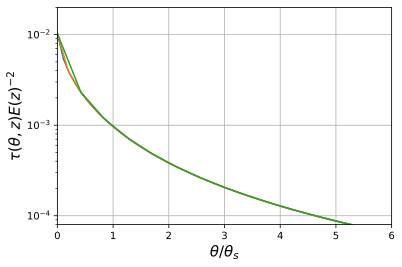

In [1057]:
thetas = np.linspace(0,40)
plt.semilogy(thetas/7.5, cNFW(thetas, 0.1, M=3e14)*(bkd.hubble_parameter(0.1)/67.8)**(-2))
plt.semilogy(thetas/4.16, cNFW(thetas, 0.2, M=3.3e14)*(bkd.hubble_parameter(0.2)/67.8)**(-2))
plt.semilogy(thetas/1.93, cNFW(thetas, 0.7, M=6e14)*(bkd.hubble_parameter(0.7)/67.8)**(-2))
plt.grid()
plt.ylim(8e-5,2e-2)
plt.xlim(0,6)
plt.xlabel(r'$\theta/\theta_s$',size=15)
plt.ylabel(r'$\tau(\theta,z)E(z)^{-2}$',size=15)
plt.

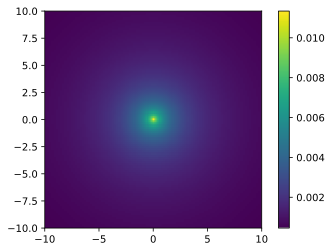

In [1054]:
plt.imshow(cNFW_grid(0.1,M=3e14),extent=[-10,10,-10,10])
plt.colorbar()

In [1060]:
gTau(1)

0.012981789534847

In [1070]:
Pc_z0p2, Qc_z0p2, Uc_z0p2 = PlotRemoteQuadrupole(0.2, nside=2048, return_QU=1)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


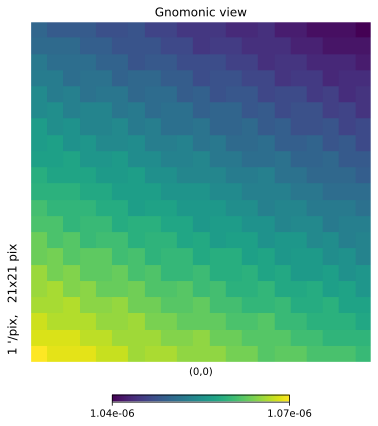

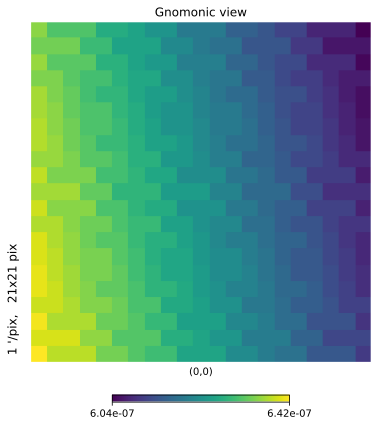

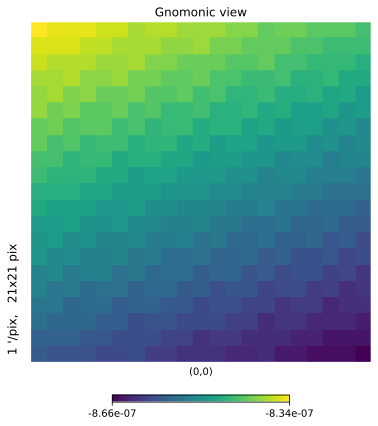

In [1106]:
Pcorr_zoom = hp.gnomview(Pc_z0p2, reso=1, xsize=21, return_projected_map=1)
Qcorr_zoom = hp.gnomview(Qc_z0p2, reso=1, xsize=21, return_projected_map=1)
Ucorr_zoom = hp.gnomview(Uc_z0p2, reso=1, xsize=21, return_projected_map=1)

In [1137]:
tau_cut = cNFW_grid(0.05,M=3e14,reso=1)

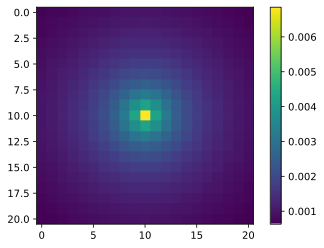

In [1138]:
plt.imshow(tau_cut*Qcorr_zoom*1e6);plt.colorbar()

In [1108]:
N = np.eye(tau_cut.size)*2

In [1119]:
d = (Qcorr_zoom + Ucorr_zoom*1j)*tau_cut*1e6 + 

In [1120]:
np.dot(tau_cut.flatten(), np.dot(np.linalg.inv(N),tau_cut.flatten()))

0.0007477328883016105

In [1113]:
np.dot(tau_cut.flatten(), np.dot(np.linalg.inv(N),d.flatten()))

(0.00046617353072873614-0.0006354476563376793j)

In [1114]:
np.sum(tau_cut**2)

0.0014954657766032215

In [1121]:
(0.00046617353072873614-0.0006354476563376793j)/0.0007477328883016105


(0.623449279845903-0.8498324285040154j)

In [1122]:
np.sum(tau_cut*d)/np.sum(tau_cut**2)

(0.6234492798459028-0.849832428504015j)

In [1145]:
np.sqrt(7.1**2/np.sum(tau_cut**2))

137.83864457824728

In [913]:
x = np.matrix(np.arange(1,2).reshape((1,1)), dtype=complex)
x -= 1j
x

matrix([[1.-1.j]])

In [916]:
np.outer(x.getH(),x)

array([[2.+0.j]])

In [2]:
x

NameError: name 'x' is not defined

In [3]:
plt.loglog(theory.cltt)

NameError: name 'plt' is not defined